# Trait Simulation - VCM Power Example

Authors: Sarah Ji, Janet Sinsheimer, Kenneth Lange, Hua Zhou

In this notebook we show how to use the `TraitSimulation.jl` package we illustrate how TraitSimulation.jl can easily simulate traits from genotype data, all within the OpenMendel universe. Operating within this universe brings potential advantages over the available software(s) when needed for downstream analysis or study design. 

Using just a few calls on the command line to the appropriate packages within the OpenMendel, we demonstrate in three easy examples the utilities of the TraitSimulation.jl package.

Reference on Introduction to Variance Component Models in Genetic Setting, textbook link.


## Background

There is a lack of software available to geneticists who wish to calculate power and sample sizes in designing a study on genetics data. Typically, the study power depends on assumptions about the underlying disease model.  Many power calculating software tools operate as a black box and do not allow for customization.  To develop custom tests, researchers can develop their own simulation procedures to carry out power calculations.  One limitation with many existing methods for simulating traits conditional on genotypes is that these methods are limited to normally distributed traits and to fixed effects. 

This software package, TraitSimuliation.jl addresses the need for simulated trait data in genetic analyses.  This package generates data sets that will allow researchers to accurately check the validity of programs and to calculate power for their proposed studies. This package gives users the ability to easily simulate phenotypic traits under generalized linear models (GLMs) or variance component models (VCMs) conditional on PLINK formatted genotype data [3]. In addition, we include customized simulation utilities that accompany specific genetic analysis options in Open-Mendel; for example, ordered, multinomial traits. We demonstrate these simulation utilities on the example dataset described below.


## Demonstration

##### Example Data

We use the OpenMendel package [SnpArrays.jl](https://openmendel.github.io/SnpArrays.jl/latest/) to both read in and write out PLINK formatted files. 

Based on several different features in the EHR including diabetes diagnostic codes, diabetes medication, hyperglycemia in blood results defined by HbA1c and fasting glucose levels, and presence of diabetes process of care codes, the algorithm categorizes individuals into different categories that relate to how likely they are to have diabetes. 

For convenience we use the common assumption that the residual covariance among two relatives can be captured by the additive genetic variance times twice the kinship coefficient.

In each example the user can specify the simulation model parameters, along with the number of repitions for each simulation model as desired. By default, the simulation will return the result of a single simulation.


### Double check that you are using Julia version 1.0 or higher by checking the machine information

In [96]:
versioninfo()

Julia Version 1.3.0
Commit 46ce4d7933 (2019-11-26 06:09 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i9-9920X CPU @ 3.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


In [97]:
using Random, Plots, DataFrames, LinearAlgebra, StatsFuns, CSV
using SnpArrays, TraitSimulation, GLM, StatsBase, VarianceComponentModels
Random.seed!(1234);

# Reading genotype data using SnpArrays

First use `SnpArrays.jl` to read in the genotype data. We use PLINK formatted data with the same prefixes for the .bim, .fam, .bed files.

SnpArrays is a very useful utility and can do a lot more than just read in the data. More information about all the functionality of SnpArrays can be found at:
https://openmendel.github.io/SnpArrays.jl/latest/

As missing genotypes are often due to problems making the calls, the called genotypes at a marker with too much missing genotypes are potentially unreliable. By default, SnpArrays filters to keep only the genotypes with success rates greater than 0.98 and the minimum minor allele frequency to be 0.01. If the user wishes to change the stringency, change the number given in filter according to [SnpArrays](https://openmendel.github.io/SnpArrays.jl/latest/#Fitering-1).

In [190]:
filename = "tmp.filter.n1754"
sample_snps = SnpArray(filename * ".bed")

1754×194753 SnpArray:
 0x02  0x02  0x03  0x03  0x03  0x03  …  0x03  0x02  0x02  0x02  0x03  0x03
 0x03  0x03  0x03  0x02  0x03  0x03     0x03  0x03  0x02  0x02  0x03  0x02
 0x03  0x03  0x03  0x03  0x03  0x03     0x03  0x02  0x02  0x02  0x03  0x03
 0x02  0x03  0x02  0x03  0x03  0x02     0x03  0x03  0x03  0x02  0x03  0x02
 0x03  0x03  0x03  0x03  0x03  0x03     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x02  0x03  0x03  …  0x03  0x03  0x02  0x02  0x03  0x03
 0x02  0x03  0x02  0x03  0x03  0x02     0x03  0x03  0x03  0x03  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x03  0x02  0x02  0x02  0x03  0x02
 0x02  0x03  0x02  0x02  0x02  0x02     0x03  0x03  0x03  0x02  0x03  0x00
 0x03  0x03  0x03  0x03  0x02  0x03     0x02  0x03  0x03  0x03  0x03  0x02
 0x03  0x03  0x03  0x03  0x03  0x03  …  0x03  0x03  0x03  0x02  0x03  0x00
 0x03  0x03  0x03  0x03  0x03  0x03     0x03  0x03  0x00  0x00  0x03  0x03
 0x03  0x03  0x03  0x03  0x03  0x03     0x03  0x02  0x00  0x00  0x03  0x03
   

In [191]:
sample_snp_data = SnpData(filename);

The published hypertension GWAS analysis includes the following covariates: sex, center, age, age2, BMI, and the top ten principal components to adjust for ancestry/relatedness.


# Construct Genetic Model: (VCM Parameter Specification)

Say that you have the the classical setting in genetics, two variance components, one for the additive genetic variance and one for the environmental variance. For simulating $d$ correlated traits for $n$ related people under the VCM, users can specify their covariance structures as follows.

$$Y_{n \times d} \sim \text{MatrixNormal}(\mathbf{M}_{n \times d} = XB, \Omega_{nd \times nd} = \Sigma_A \otimes V_A + \Sigma_E \otimes V_E)$$

In [192]:
bimfile = sample_snp_data.snp_info # store the snp_info with the snp names
snpid  = bimfile[!, :snpid] # store the snp names in the snpid vector
causal_snp_index = findfirst(x -> x == "rs11240779", snpid); # find the index of the snp of interest by snpid

Here are the minor allele frequencies

In [193]:
minor_allele_freq = round.(maf(sample_snps), digits = 3)

194753-element Array{Float64,1}:
 0.154
 0.038
 0.126
 0.108
 0.029
 0.124
 0.222
 0.1  
 0.249
 0.403
 0.204
 0.174
 0.394
 ⋮    
 0.239
 0.057
 0.419
 0.031
 0.024
 0.378
 0.023
 0.042
 0.243
 0.426
 0.081
 0.299

Additionally, we will control for sex, with females as the baseline group, `sex = 0.0`. We want to find the index of this causal locus in the snp_definition (.bim) file and then subset that locus from the genetic marker data above. Make note of julia's ternary operator '?' which allows us to make this conversion efficiently!

Using SnpArrays.jl we can then use the `convert` and `@view` commands to get the appropriate conversion from SnpArray to a computable vector of Float64. 

## Quick QC 
We can take a quick moment to insure the correct value for the allele frequency of the causal snp.  This will act as a quick quality control (QC) step to validate that the user has found the right snp and that it has the expected allele frequency.

In [194]:
maf_cs = minor_allele_freq[causal_snp_index]

0.222

In [195]:
# Generating Effect Sizes from Chisquared(df = 1) density
chisq_coeff = round(chisqpdf(1, maf_cs), digits = 3)

0.758

In [198]:
GRM = grm(sample_snps, minmaf = 0.05)

1754×1754 Array{Float64,2}:
  0.498573     -0.000643301  -0.00258662   …  -0.0069214     0.0049598  
 -0.000643301   0.495279     -0.00312802       0.00131516    0.00231883 
 -0.00258662   -0.00312802    0.501911         0.00478806    0.00450852 
  0.00405814    0.00774299   -0.00513358       0.000432786   0.00158882 
 -0.0020606     0.00328277    0.00834473      -0.000618117  -0.00784694 
  0.000552111  -0.00186035    0.00370651   …  -2.03149e-5   -0.00476454 
  0.00655272   -0.00102355    0.00194366       0.00157696    0.00170861 
  0.00273434   -0.000458866  -0.00737314       0.00544303   -0.00113245 
 -0.00361704    0.0077276     0.00417113       0.00615671   -0.00444713 
  0.0098195    -0.000556163  -0.00614806       0.00240151   -0.00194491 
 -0.00223621   -0.000821999   0.00436483   …   0.00831013    0.00238982 
 -0.0037268     0.00190196   -0.0117186       -0.0023695    -0.00692049 
 -0.00587711    0.000770298   8.27384e-5       0.00677608    0.000791218
  ⋮                    

# Power Calculation

Now we show how to simulate from customized simulation models that accompany specific genetic analysis options in OpenMendel; for example, ordered, multinomial traits and Variance Component Models.


This example illustrates the use of the simulations to generates data sets allowing researchers to accurately check the validity of programs and to calculate power for their proposed studies. 

We illustrate this example in three digestable steps: 
   * The first by simulating genotypes and covariate values representative for our study population.
   * Carry over the simulated design matrix from (1) to create the OrderedMultinomialTrait model object.
   * Simulate off the OrderedMultinomialTrait model object created in (2) and run the power analyses for the desired significance level.


### convert
By default `convert` function translates genotypes according to the *additive* SNP model, which essentially counts the number of **A2** allele (0, 1 or 2) per genotype. Other SNP models are *dominant* and *recessive*, both in terms of the **A2** allele.

| Genotype | `SnpArray` | `model=ADDITIVE_MODEL` | `model=DOMINANT_MODEL` | `model=RECESSIVE_MODEL` |    
|:---:|:---:|:---:|:---:|:---:|  
| A1,A1 | 0x00 | 0 | 0 | 0 |  
| missing | 0x01 | NaN | NaN | NaN |
| A1,A2 | 0x02 | 1 | 1 | 0 |  
| A2,A2 | 0x03 | 2 | 1 | 1 |  

If desired, the user can decide to specify alternative model parameters found in the [SnpArrays](https://openmendel.github.io/SnpArrays.jl/latest/#convert-and-copyto!-1) documentation.

In [199]:
locus = convert(Vector{Float64}, @view(sample_snps[:, causal_snp_index]), impute = true)

1754-element Array{Float64,1}:
 2.0
 1.0
 2.0
 0.0
 2.0
 1.0
 1.0
 2.0
 0.0
 2.0
 2.0
 2.0
 2.0
 ⋮  
 1.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

## Design Matrix

Now we concatenate the simulated causal locus, transformed to Float64, to the other covariates we want to control for in the study design.

The published hypertension GWAS analysis includes the following covariates: sex, center, age, age2, BMI, and the top ten principal components to adjust for ancestry/relatedness.

In [203]:
n = length(locus)
published_covariate_data = CSV.read("/mnt/UKBiobank/ukbdata/ordinalanalysis/Covariate_Final.csv")
covariates = published_covariate_data[1:n, 1:10]

,FID,IID,sex,center,age,age2,chip,bmi,hyptens,AveSBP
,Int64,Int64,Int64,Int64,Int64,Int64,String,Float64,Int64,Float64
1,1000019,1000019,1,11016,62,3844,ChipOne,29.3424,0,118.0
2,1000078,1000078,1,11009,51,2601,ChipOne,31.0375,2,134.0
3,1000081,1000081,1,11014,47,2209,ChipOne,23.335,2,132.5
4,1000105,1000105,0,11010,42,1764,ChipOne,21.5793,0,104.5
5,1000112,1000112,1,11021,55,3025,ChipOne,26.7327,2,139.0
6,1000129,1000129,1,11009,63,3969,ChipOne,26.7034,3,141.0
7,1000141,1000141,0,11008,51,2601,ChipOne,35.1706,1,128.0
8,1000164,1000164,0,11011,45,2025,ChipOne,25.235,1,122.0
9,1000224,1000224,1,11010,52,2704,ChipOne,31.6387,3,158.0


In [204]:
age = Float64.(covariates[!, :age])
sex = Float64.(covariates[!, :sex])
center = Int64.(covariates[!, :center])
bmi = Float64.(covariates[!, :bmi])
avg_SBP = Float64.(covariates[!, :AveSBP])

X_cov = DataFrame(sex = sex, center = center, age = age, age2 = age.^2, bmi = bmi)
Data = DataFrame(y = avg_SBP, sex = sex, center = center, age = age, age2 = age.^2, bmi = bmi, locus = locus)
X_full = hcat(X_cov, DataFrame(locus = locus))

,sex,center,age,age2,bmi,locus
,Float64,Int64,Float64,Float64,Float64,Float64
1,1.0,11016,62.0,3844.0,29.3424,2.0
2,1.0,11009,51.0,2601.0,31.0375,1.0
3,1.0,11014,47.0,2209.0,23.335,2.0
4,0.0,11010,42.0,1764.0,21.5793,0.0
5,1.0,11021,55.0,3025.0,26.7327,2.0
6,1.0,11009,63.0,3969.0,26.7034,1.0
7,0.0,11008,51.0,2601.0,35.1706,1.0
8,0.0,11011,45.0,2025.0,25.235,2.0
9,1.0,11010,52.0,2704.0,31.6387,0.0


## Phenotype Simulation:

Now that we have our simulated design matrix with the desired SNP of interest, we can simulate our phenotypes on the simulated data under different TraitSimulation models. To illustrate, we demonstrate on the `VCMTrait` model object in TraitSimulation.jl.

In [205]:
β_init = coeftable(lm(@formula(y ~ sex + center + age + age2 + bmi), Data)).cols[1]

6-element Array{Float64,1}:
 35.46020099213837    
  4.899567900502786   
  0.003918867932375633
  0.5981775857128243  
  0.000504039537344137
  0.7535032233943749  

In [207]:
n = size(GRM, 1)
I_n = Matrix{Float64}(I, n, n)

totalvc = @vc [0.1][:, :] ⊗ GRM + [0.9][:, :] ⊗ I_n
genetic_model = VCMTrait(Matrix(X_cov), β_init[2:6,:], totalvc)

Variance Component Model
  * number of traits: 1
  * number of variance components: 2
  * sample size: 1754

In [208]:
β_full = vcat(β_init[2:6], chisq_coeff)

6-element Array{Float64,1}:
 4.899567900502786   
 0.003918867932375633
 0.5981775857128243  
 0.000504039537344137
 0.7535032233943749  
 0.758               

In [209]:
genetic_model_test = VCMTrait(Matrix(X_full), β_full[:, :], totalvc)

Variance Component Model
  * number of traits: 1
  * number of variance components: 2
  * sample size: 1754

## `Power Calculation:`

We use the following function to generate the p-values for the simulated power example for the ordered multinomial regression model. We range effect sizes in the vector γs, which collects effect sizes from 0 to 1 in increments of 0.05. As expected, the power increases as the effect size increases. 
    

In [210]:
γs = collect(0.0:0.05:0.5)

11-element Array{Float64,1}:
 0.0 
 0.05
 0.1 
 0.15
 0.2 
 0.25
 0.3 
 0.35
 0.4 
 0.45
 0.5 

Suppose we want to see a particular SNP has an effect on a given phenotype after accounting for relatedness among individuals. Here we fit variance component model with a single SNP *s* as fixed effect. 

$$\hspace{5em}  \mathbf{y} = \mathbf{X}\mathbf{\beta} + \mathbf{G}_s \gamma + \mathbf{g} + \mathbf{\epsilon} \hspace{5em} (1)$$

\begin{equation}
\begin{array}{ll}
\mathbf{g} \sim N(\mathbf{0}, \sigma_g^2\mathbf{\Phi}) \\
\mathbf{\epsilon} \sim N(\mathbf{0}, \sigma_e^2\mathbf{I})
\end{array}
\end{equation}

where 

* $\mathbf{y}$: phenotype 



and 


* Fixed effects:
    * $\mathbf{X}$: matrix of covariates including intercept
    * $\beta$: vector of covariate effects, including intercept
    * $\mathbf{G}_s$: genotype of SNP *s*
    * $\gamma$: (scalar) association parameter of interest, measuring the effect of genotype on phenotype  
* Random effects:
    * $\mathbf{g}$: random vector of polygenic effects with $\mathbf{g} \sim N(\mathbf{0}, \sigma_g^2 \mathbf{\Phi})$
        * $\sigma_g^2$: additive genetic variance
        * $\mathbf{\Phi}$: matrix of pairwise measures of genetic relatedness 
    * $\epsilon$: random vector with $\epsilon \sim N(\mathbf{0}, \sigma_e^2\mathbf{I})$
        * $\sigma_e^2$: non-genetic variance due to non-genetic effects assumed to be acting independently on individuals



To test whether SNP *s* is associated with phenotype, we fit two models. First consider the model without SNP *s* as fixed effects (aka null model): 

$$\hspace{5em}  \mathbf{y} = \mathbf{X}\mathbf{\beta} + \mathbf{g} + \mathbf{\epsilon} \hspace{5em} (2)$$

and the model with SNP *s* as fixed effects (1). Then we can compare the log likelihood to see if there is improvement in the model fit with inclusion of the SNP of interest. 

Each column of this matrix represents each of the detected effect sizes, and each row of this matrix represents each simulation for that effect size. The user feeds into the function the number of simulations, the vector of effect sizes, the TraitSimulation.jl model object, and the random seed.

For GLMTrait objects, the `realistic_power_simulation` function makes the appropriate calls to the GLM.jl package to get the simulation p-values obtained from testing the significance of the causal locus using the Wald Test by default. However since the GLM.jl package has its limitations, we include additional power utilities that make the appropriate function calls to the [OrdinalMultinomialModels](https://openmendel.github.io/OrdinalMultinomialModels.jl/stable/#Syntax-1) to get the p-value obtained from testing the significance of the causal locus.


For each effect size in $\gamma_s,$ in each column we have the p-values obtained from testing the significance of the causal locus `nsim = 100` times under the VCM, and the `randomseed = 1234`.

In [ ]:
nsim = 1000
randomseed = 1234
simulated_pvalues = power_simulation(nsim, γs, genetic_model_test, β_full[:, :], randomseed);
rename!(DataFrame(simulated_pvalues), [Symbol("γs = $(γs[i])") for i in 1:length(γs)])

 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 
 . . . 


Now we find the power of each effect size in the user-specified γs vector at the specified alpha level of significance, and plot the trajectory using the Plots.jl package.

In [125]:
α = 0.0000000005
power_effectsize = power(simulated_pvalues, α)

11-element Array{Float64,1}:
 0.0  
 0.001
 0.12 
 0.84 
 0.999
 1.0  
 1.0  
 1.0  
 1.0  
 1.0  
 1.0  

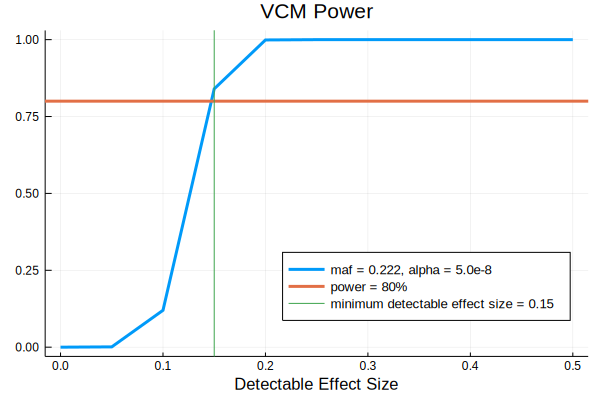

In [142]:
plot(γs, power_effectsize, title = "VCM Power", label = "maf = $maf_cs, alpha = $α", lw = 3 , legend = :bottomright, legendfontsize= 9)  # plot power
xlabel!("Detectable Effect Size")
hline!([.8], label = "power = 80%", lw = 3)
vline!([.15], label = "minimum detectable effect size = 0.15")
#savefig("/home/sarahji/TraitSimulation.jl/docs/vcmpower.pdf")

## Citations: 

[1] Lange K, Papp JC, Sinsheimer JS, Sripracha R, Zhou H, Sobel EM (2013) Mendel: The Swiss army knife of genetic analysis programs. Bioinformatics 29:1568-1570.`


[2] OPENMENDEL: a cooperative programming project for statistical genetics.
[Hum Genet. 2019 Mar 26. doi: 10.1007/s00439-019-02001-z](https://www.ncbi.nlm.nih.gov/pubmed/?term=OPENMENDEL).

[3] German, CA, Sinsheimer, JS, Klimentidis, YC, Zhou, H, Zhou, JJ. Ordered multinomial regression for genetic association analysis of ordinal phenotypes at Biobank scale. Genetic Epidemiology. 2019; 1– 13. https://doi.org/10.1002/gepi.22276
